In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.impute import SimpleImputer
import category_encoders as ce  # May need to pip install
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight


import warnings
warnings.filterwarnings('ignore')

## Section 1: Ingesting data and pre processing

Steps:

- Ingest data
- Drop columns with > 50% observations missing
- For the remaining missing columns, impute mean for numeric types
- For the categorical columns with missing values, add a missing category
- One hot encode all categorical variables
- Create a list of features and target variable

In [4]:
# Ingest the data
data = '../Data/accident_data.csv'
df = pd.read_csv(data)
df.head()

,CRASH_CRN,DISTRICT,CRASH_COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,LANE_COUNT,RDWY_ORIENT,ROAD_OWNER,ROUTE,SPEED_LIMIT,SEGMENT,OFFSET,STREET_NAME,TOT_INJ_COUNT,SCHOOL_BUS_UNIT
0,2004000001,11,2,2454,02454,2004,1,5,257.0,2.0,...,2.0,E,2.0,2032,35.0,10.0,1000.0,LEWIS RUN RD,NaN,NaN
1,2004000010,11,2,2440,02440,2004,1,5,1027.0,10.0,...,2.0,W,3.0,NaN,35.0,NaN,NaN,COAL VALLEY RD,NaN,NaN
2,2004000016,11,2,2203,02203,2004,1,5,1839.0,18.0,...,2.0,W,2.0,3082,35.0,NaN,NaN,CLINTON FRANKFORT RD,NaN,NaN
3,2004000022,11,2,2404,02404,2004,1,6,914.0,9.0,...,2.0,N,4.0,NaN,25.0,NaN,NaN,NORTH BALPH AV,NaN,NaN
4,2004000030,11,2,2419,02419,2004,1,5,2230.0,22.0,...,2.0,S,4.0,NaN,20.0,NaN,NaN,THORNBERRY DR,NaN,NaN


In [5]:
# What variables have missing values, how much and is that variable relevant

# Data dictionary
data_dict = '../Data/accident_data_dict.csv'
data_dict = pd.read_csv(data_dict)

# Missing columns in data
prop_missing = df.isna().mean()

# create a new dataframe with the 'column' and 'prop_missing' variables
missing_df = pd.DataFrame({'column': prop_missing.index, 'prop_missing': prop_missing.values})
missing_df = missing_df[missing_df.prop_missing > 0]

print(f"There are {len(missing_df)} variables which have some missing values. The table below shows the variable, it's description and what proportion is missing")

# Display table
missing_df = pd.merge(missing_df, data_dict, on='column', how='inner')
missing_df.sort_values(by='prop_missing', ascending=False).head(20)

There are 47 variables which have some missing values. The table below shows the variable, it's description and what proportion is missing


,column,prop_missing,type,label,description
16,SPEC_JURIS_CD,0.994239,text,Special Jurisdiction Code,Code that defines any special jurisdiction – o...
15,RDWY_SURF_TYPE_CD,0.994202,text,Roadway Surface Type Code\t,Code for the Roadway surface type –only for fa...
23,WZ_CLOSE_DETOUR,0.992037,text,Work Zone Closed Detour\t,Was traffic rerouted due to work zone?(Y/N); 0...
28,WZ_OTHER,0.991746,text,Work Zone Special Flag\t,Was this a special type of work zone? (Y/N) 0 ...
24,WZ_FLAGGER,0.991645,text,Work Zone Flagman Flag\t,"Did Work zone have a flagman? (Y/N) 0 = No, 1 ..."
27,WZ_MOVING,0.991409,text,Work Zone Moving Flag\t,Was there moving work in the zone? (Y/N) 0 = N...
29,WZ_SHLDER_MDN,0.989960,text,Work Zone Shoulder/Median Flag\t,Was a median/shoulder in the zone?; (Y/N) 0 = ...
26,WZ_LN_CLOSURE,0.988044,text,Work Zone Lane Closure Flag\t,"Did Work zone have a patrolman? (Y/N) 0 = No, ..."
21,CONS_ZONE_SPD_LIM,0.982874,int4,Construction Zone Speed Limit,Speed limit for the Construction Zone
25,WZ_LAW_OFFCR_IND,0.982864,text,Work Zone Patrolman Flag\t,"Did Work zone have a patrolman? (Y/N) 0 = No, ..."


In [6]:
# Dealing with missing values

# Logic: If a variable has more than 50% of observations missing, drop that variable
# Logic: Else, if it's an int variable, impute mean. If it's a text variable, create a missing category

# Drop vars
clean_df = df.copy()
vars_to_drop = list(missing_df[missing_df.prop_missing>=0.5]['column'])
clean_df = df.drop(columns=vars_to_drop, axis=1)

# Impute mean for missing values in numerical columns
numerical_cols = clean_df.select_dtypes(include=['int', 'float']).columns
imputer = SimpleImputer(strategy='mean')
clean_df[numerical_cols] = imputer.fit_transform(clean_df[numerical_cols])

# Add a missing category and make text columns categorical
# For this we have to refer to the data_dict to see which columns are of type text
text_cols = clean_df.select_dtypes(include=['object']).columns
var_types = data_dict.set_index('column')['type'].to_dict()
text_vars = [var for var in var_types.keys() if var_types[var] == 'text' 
             and var not in vars_to_drop 
             and 'CRN' not in var # These are unique identifiers
             and 'TUDE' not in var # Don't want to encode lat longs  
             and 'STREET_NAME' not in var] # Don't want to encode street name as too many values  

clean_df[text_vars] = clean_df[text_vars].fillna('missing').astype('category')


In [7]:
# Encoding categorical variables (takes some time to run, ~ 2 mins)
cat_vars = text_vars
# Initialize the OneHotEncoder from category_encoders
one_hot_enc = ce.OneHotEncoder(cols=cat_vars, use_cat_names=True)

# Fit the encoder on your data and transform the data
cat_encoded = one_hot_enc.fit_transform(clean_df[cat_vars])
df_encoded = pd.concat([clean_df.drop(cat_vars, axis=1), cat_encoded], axis=1)

In [8]:
# Store feature and target vars to be used in the next section
feature_vars = [var for var in df_encoded.columns if 'CRN' not in var
                and 'TUDE' not in var
                and 'STREET_NAME' not in var
                and 'FATAL_OR_MAJ_INJ' not in var
                and 'INJ' not in var and 'FATAL' not in var
                and 'COUNT' not in var and 'MAX_SEVERITY_LEVEL' not in var] # The last 4 are vars which one won't observe during prediction time and hence cause leakage

target_var = 'FATAL_OR_MAJ_INJ'

## Section 2: Predictive modelling

In [54]:
# split the data into train and test sets
X = df_encoded[feature_vars]
y = df_encoded[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Classification report for random forest classifier:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     63253
         1.0       1.00      0.00      0.00      1735

    accuracy                           0.97     64988
   macro avg       0.99      0.50      0.49     64988
weighted avg       0.97      0.97      0.96     64988



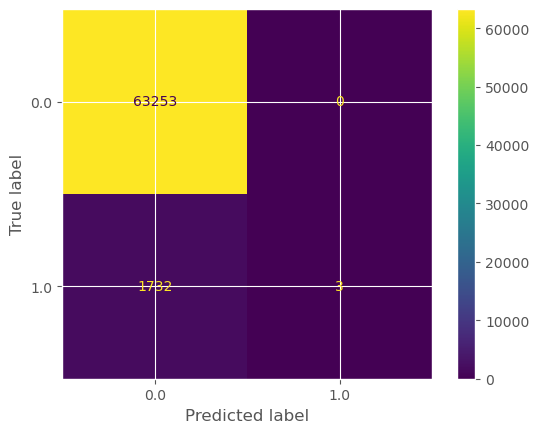

In [55]:
# Fit a Random Forest Model
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Generate a classification report
print("Classification report for random forest classifier:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.show()

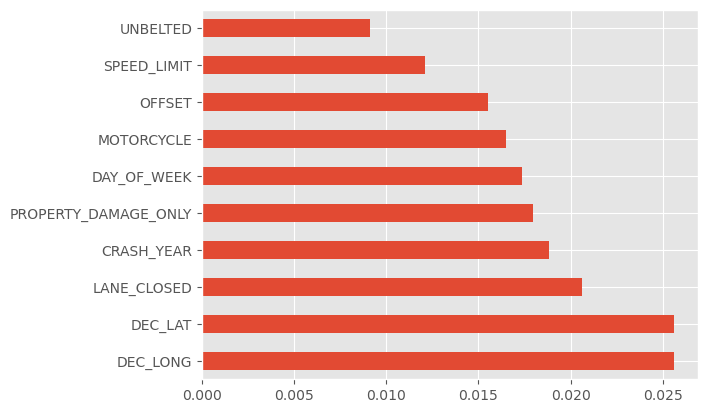

In [56]:
feat_importances_rfc = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances_rfc.nlargest(10).plot(kind='barh')
plt.show()


The RF model is not predicting any observation as 1 because of massive class imbalance. So we need to fix that

### RF with balanced class

In [15]:
# Memory intensive
# # Fixing class imbalance
# smote = SMOTE()
# X = df_encoded[feature_vars]
# y = df_encoded[target_var]
# X_resampled, y_resampled = smote.fit_resample(X, y)
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


Classification report for random forest classifier:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     63253
         1.0       1.00      0.00      0.00      1735

    accuracy                           0.97     64988
   macro avg       0.99      0.50      0.49     64988
weighted avg       0.97      0.97      0.96     64988



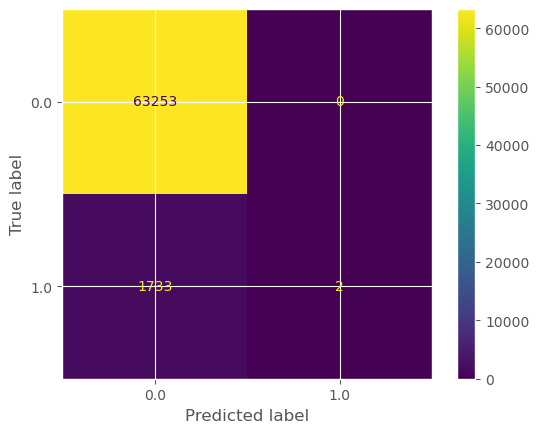

In [69]:
# Fit a Random Forest Model after reweighting
rf = RandomForestClassifier(n_estimators=300,
                            n_jobs=-1,
                            class_weight='balanced')

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Generate a classification report
print("Classification report for random forest classifier:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.show()

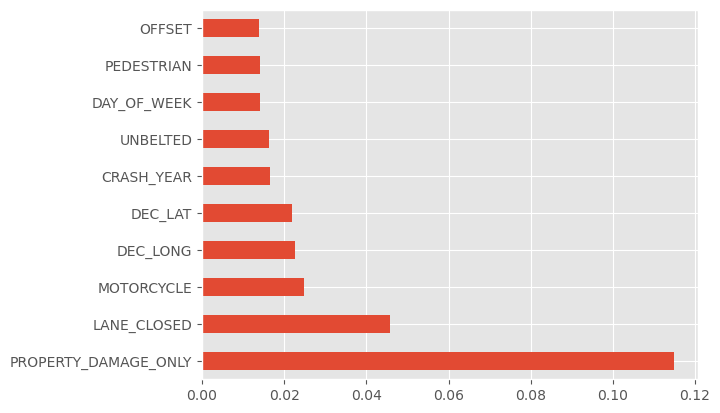

In [70]:
feat_importances_rfc = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances_rfc.nlargest(10).plot(kind='barh')
plt.show()


Better, but pretty bad recall on class 1. Let's try a model where we randomly drop some class 0 observations to restore balance

In [80]:
# Specify the proportion of target=0 observations to drop
prop_to_drop = 0.9 

# Identify the indices of the target=0 observations
class_0_indices = df_encoded.index[df_encoded[target_var] == 0]

# Randomly select a subset of target=0 indices to drop
num_to_drop = int(len(class_0_indices) * prop_to_drop)
drop_indices = np.random.choice(class_0_indices, num_to_drop, replace=False)

# Drop the selected indices from the DataFrame
df_encoded_trimmed = df_encoded.drop(drop_indices)

X = df_encoded_trimmed[feature_vars]
y = df_encoded_trimmed[target_var]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Classification report for random forest classifier:
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      6381
         1.0       0.79      0.37      0.50      1690

    accuracy                           0.85      8071
   macro avg       0.82      0.67      0.71      8071
weighted avg       0.84      0.85      0.82      8071



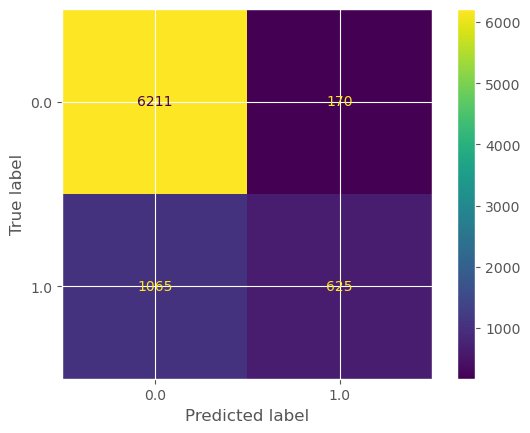

In [84]:
# Fit a Random Forest Model after reweighting
rf = RandomForestClassifier(n_estimators=500,
                            n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Generate a classification report
print("Classification report for random forest classifier:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.show()

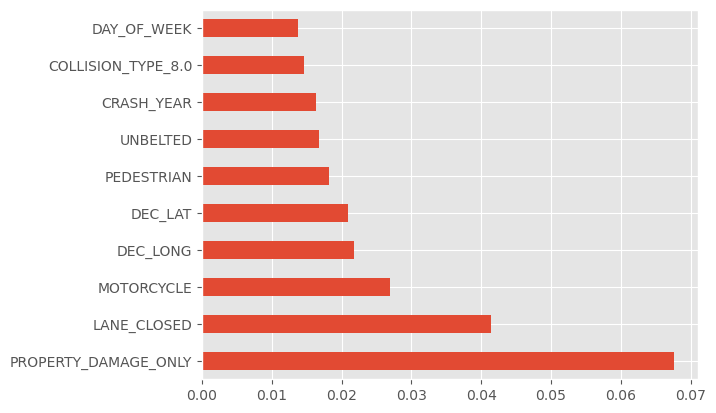

In [85]:
feat_importances_rfc = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances_rfc.nlargest(10).plot(kind='barh')
plt.show()

Looks like this performs the best (at the cost of some potential bias). The precision of the positive class is quite high, which is good. 

### Logistic regression of subsampled dataset

Classification report for Logistic Regression Classifier:
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.90      6381
         1.0       0.65      0.57      0.61      1690

    accuracy                           0.85      8071
   macro avg       0.77      0.74      0.76      8071
weighted avg       0.84      0.85      0.84      8071



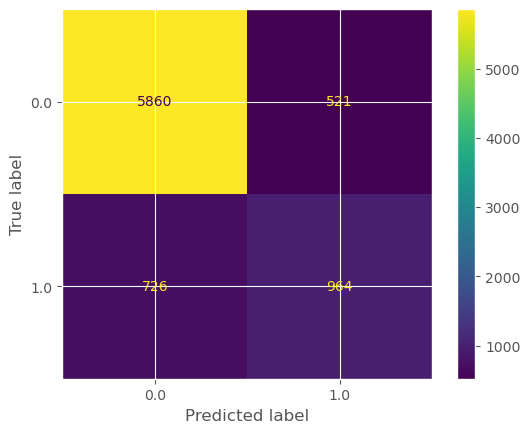

In [88]:
# Trying the same as above but for LR
# Fit a Random Forest Model after reweighting
lr = LogisticRegression(C=100, penalty='l2')

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Generate a classification report
print("Classification report for Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot()
plt.show()

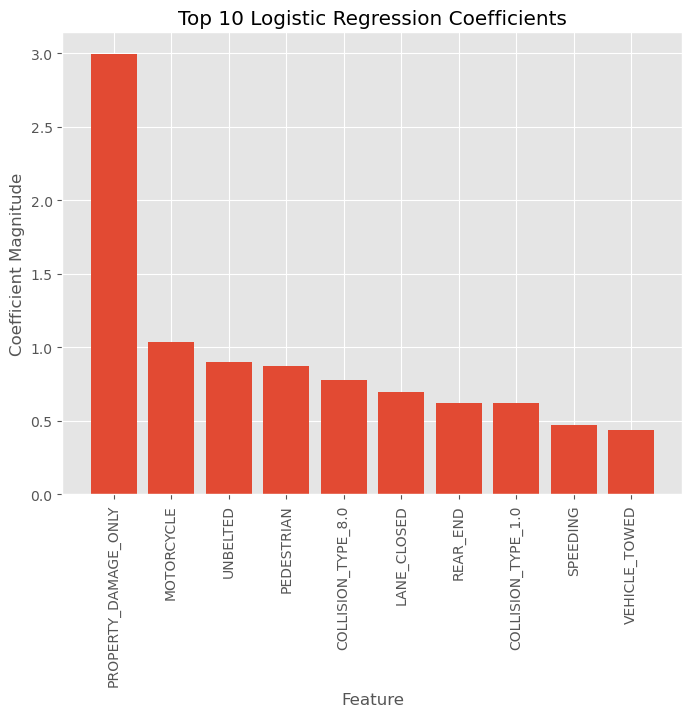

In [90]:
coefficients = lr.coef_[0]
feature_names = X_train.columns

# Calculate the absolute value of the coefficients
abs_coefs = np.abs(coefficients)

# Sort the coefficients in descending order
sorted_idx = abs_coefs.argsort()[::-1]

# Plot the top 10 coefficients
top_n = 10
plt.figure(figsize=(8, 6))
plt.bar(range(top_n), abs_coefs[sorted_idx][:top_n])
plt.xticks(range(top_n), feature_names[sorted_idx][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Coefficient Magnitude")
plt.title("Top 10 Logistic Regression Coefficients")
plt.show()


Pretty similar important variables